In [1]:
import timeit
import matplotlib.pyplot as plt
import pickle
from time import time
import numpy as np

In [2]:
import sys
sys.path.append("../dnn_from_scratch")

In [3]:
from matplotlib.image import imread
import cv2

In [4]:
DATA_DIR="/home/archer/machine_learning/Celeb100k/100k"
with open(DATA_DIR+".txt","r") as f:
    names=f.read().split('\n')[:-1]

In [5]:
def get_batch(st,btsz):
    X_train=[]
    for ii in names[st:st+btsz]:
        img=imread(DATA_DIR+"/"+ii)
        img=cv2.resize(img, dsize=(28,28))#, interpolation=cv2.INTER_CUBIC)
        X_train.append(img/255*2-1)
    return np.asarray(X_train)

In [6]:
from nnet.network import Sequential,layers
from nnet.layers import conv2d,max_pool,flatten,dense,dropout,conv2d,conv2dtranspose,upsampling,reshape,BatchNormalization,Activation
from nnet import functions
from nnet import optimizers
import numpy as np

Seed: 42
Seed: 102


In [7]:
def generator():
    model=Sequential()
    model.add(dense(128*7*7,activation=functions.leakyRelu,input_shape=100))
    model.add(reshape((7,7,128)))
#     model.add(upsampling())
#     model.add(conv2d(64,kernel_size=3,activation=functions.leakyRelu))
    model.add(conv2dtranspose(64,kernel_size=3,stride=[2,2],activation=functions.leakyRelu))
    model.add(BatchNormalization())
#     model.add(upsampling())
#     model.add(conv2d(32,kernel_size=3,activation=functions.leakyRelu))
    model.add(conv2dtranspose(32,kernel_size=3,stride=[2,2],activation=functions.leakyRelu))
    model.add(BatchNormalization())
    model.add(conv2d(3,kernel_size=3,activation=functions.tanh))
    return model
g=generator()
g.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 100)                echo             0
__________________________________________________________________________________________
1 dense(dense)            (None, 6272)               leakyRelu        633472
__________________________________________________________________________________________
2 reshape(reshape)        (None, 7, 7, 128)          echo             0
__________________________________________________________________________________________
3 conv2dtranspose(conv2dt (None, 14, 14, 64)         leakyRelu        73792
__________________________________________________________________________________________
4 BatchNormalization(Batc (None, 14, 14, 64)         echo             256
__________________________________________________________________________________________
5 con

In [8]:
def discriminator():
    model=Sequential()
    model.add(conv2d(32,kernel_size=3,stride=[2,2],activation=functions.leakyRelu,input_shape=(28,28,3)))
#     model.add(max_pool())
    model.add(dropout(0.25))
    model.add(conv2d(64,kernel_size=3,stride=[2,2],activation=functions.leakyRelu))
#     model.add(max_pool())
    model.add(BatchNormalization())
    model.add(dropout(0.25))
    model.add(flatten())
    model.add(dense(256,activation=functions.leakyRelu))
    model.add(dropout(0.2))
    model.add(dense(1,activation=functions.sigmoid))
    return model
d=discriminator()
d.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 28, 28, 3)          echo             0
__________________________________________________________________________________________
1 conv2d(conv2d)          (None, 14, 14, 32)         leakyRelu        896
__________________________________________________________________________________________
2 dropout(dropout)        (None, 14, 14, 32)         echo             0
__________________________________________________________________________________________
3 conv2d(conv2d)          (None, 7, 7, 64)           leakyRelu        18496
__________________________________________________________________________________________
4 BatchNormalization(Batc (None, 7, 7, 64)           echo             256
__________________________________________________________________________________________
5 dropou

In [9]:
g.compile(optimizer=optimizers.adam,loss=functions.mean_squared_error,learning_rate=0.002)
d.compile(optimizer=optimizers.adam,loss=functions.cross_entropy_with_logits,learning_rate=0.002)

In [10]:
svdnoise=np.random.randn(64,100).astype(np.float32)
gen=g.predict(svdnoise)

In [11]:
def gen_sample():
    noise=np.random.randn(1,100).astype(np.float32)
    gen=g.predict(noise)
    plt.imshow((gen[0]+1)/2,interpolation='bicubic')
    plt.show()
    print(d.predict(gen)[0])
    gen=g.predict(svdnoise)
    plt.imshow((gen[0]+1)/2,interpolation='bicubic')
    plt.show()
    print(d.predict(gen)[0])

In [12]:
ccu=0

In [25]:
def run():
    global ccu
    batch_size=64
    dsz=len(names)
    # Label real ones as 90% real
    y_fake=np.zeros((batch_size,1),dtype=np.float32)
    y_real=np.ones((batch_size,1),dtype=np.float32)
    y_gen=np.ones((batch_size,1),dtype=np.float32)
    for step in range(dsz//batch_size):
        stt=time()
        noise=np.random.randn(batch_size,100).astype(np.float32)
        # Generate fake images from noise
        generated_images=g.predict(noise)
        # Get random real images
        real_images=get_batch(ccu,batch_size)
        ccu+=batch_size
        # Train discriminator
#         y_fake=np.random.uniform(0,0.05,(batch_size,1)).astype(np.float32)
#         y_real=np.random.uniform(0.9,1,(batch_size,1)).astype(np.float32)
        dout1=d.train_on_batch(real_images,y_real)
        dout2=d.train_on_batch(generated_images,y_fake)
        dloss=functions.cross_entropy(logits=dout2,labels=y_fake).sum()
        # Treat noised input of generator as real data
        noise=np.random.randn(batch_size,100).astype(np.float32)
        # Train generator
        gout=g.forward(noise)
        # do not train discriminator and find delta for generator
        dout,err=d.not_train_on_batch(gout,y_gen)
        g.backprop(err,g.lenseq_m1)
        g.optimizer(g.sequence,g.learning_rate,g.beta)
        if not step%50:
            gen_sample()
        print("\rProgress: {:.2f} %    {}    Dloss: {}    err: {}    Sample time: {:.3f}s    _".format(step*batch_size*100/dsz,ccu,dloss,abs(err).sum(),time()-stt),end='')

EPOCH: 1 / 2


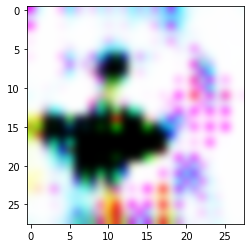

[0.99989545]


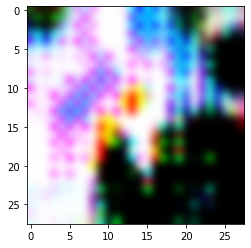

[0.99978894]
Progress: 3.14 %    11392    Dloss: 3.8026742935180664    err: 1951.5045166015625    Sample time: 0.682s    _

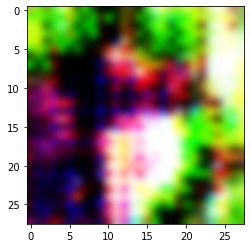

[0.8094439]


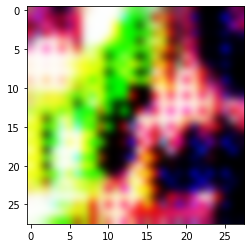

[0.9981242]
Progress: 6.34 %    14592    Dloss: 12.163537979125977    err: 3698.782470703125    Sample time: 0.761s    __

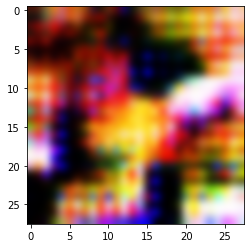

[0.9999912]


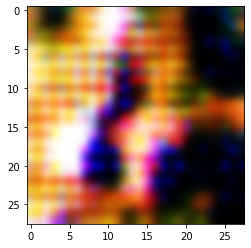

[0.5847647]
Progress: 9.54 %    17792    Dloss: 8.592645645141602    err: 6798.16552734375    Sample time: 0.797s    ___

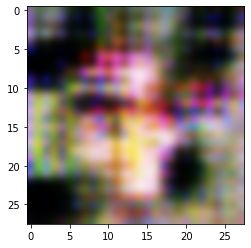

[0.0396256]


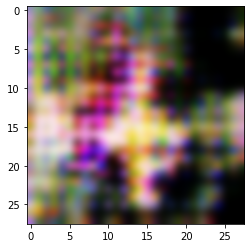

[0.9959908]
Progress: 12.74 %    20992    Dloss: 13.072620391845703    err: 8784.61328125    Sample time: 0.791s    _ __

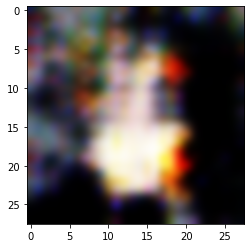

[0.00207546]


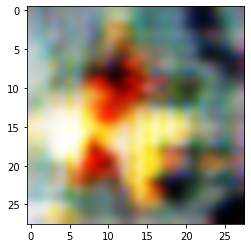

[3.0801904e-05]
Progress: 15.94 %    24192    Dloss: 8.51589584350586    err: 6973.2177734375    Sample time: 0.796s    _ __

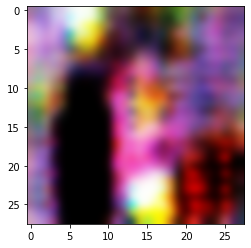

[0.00206731]


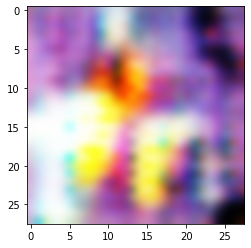

[0.03109493]
Progress: 19.14 %    27392    Dloss: 7.942342281341553    err: 14661.240234375    Sample time: 0.778s    ___

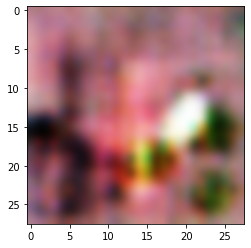

[0.07257939]


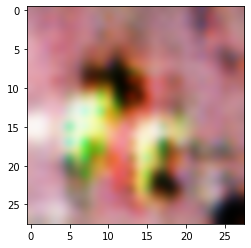

[0.58103466]
Progress: 22.34 %    30592    Dloss: 12.265657424926758    err: 12999.400390625    Sample time: 0.781s    __

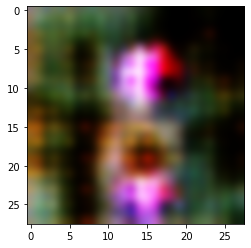

[0.00021246]


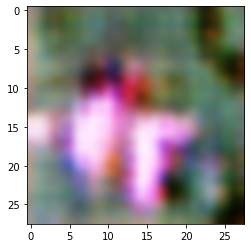

[0.00359554]
Progress: 25.54 %    33792    Dloss: 9.50358772277832    err: 10773.3212890625    Sample time: 0.773s    _ _

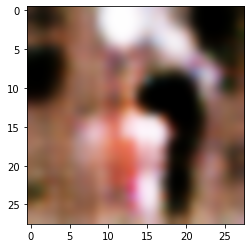

[0.05924363]


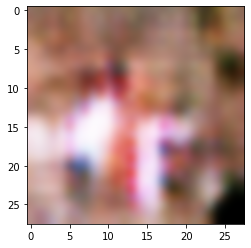

[3.1366835e-05]
Progress: 28.74 %    36992    Dloss: 17.364774703979492    err: 12864.5224609375    Sample time: 0.768s    _

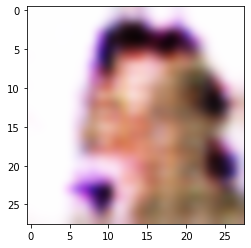

[0.00038263]


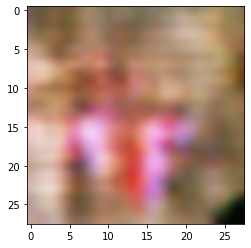

[0.00488687]
Progress: 31.94 %    40192    Dloss: 43.86705017089844    err: 14046.37890625    Sample time: 0.760s    _  _

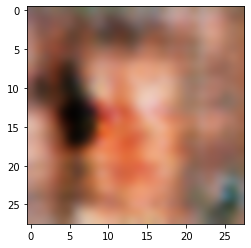

[0.0004051]


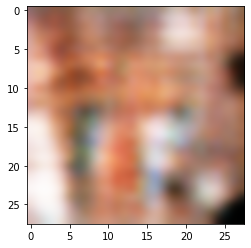

[0.00031368]
Progress: 35.14 %    43392    Dloss: 37.440303802490234    err: 17353.10546875    Sample time: 0.779s    _ _

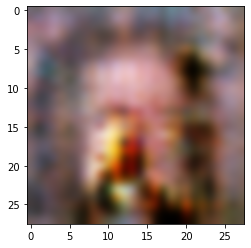

[0.01149169]


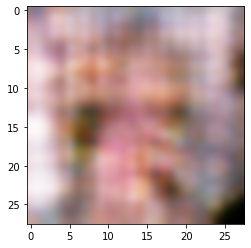

[0.00028085]
Progress: 35.71 %    43968    Dloss: 41.49612045288086    err: 15102.24609375    Sample time: 0.765s    _  _

../dnn_from_scratch/nnet/functions.py:66: RuntimeWarning: divide by zero encountered in log
  return -labels*np.log(logits)-(1-labels)*np.log(1-logits)


Progress: 38.34 %    46592    Dloss: 21.17129898071289    err: 15273.1962890625    Sample time: 0.792s    __

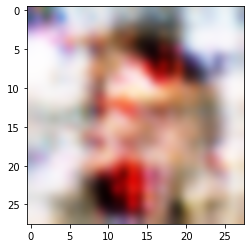

[0.8479752]


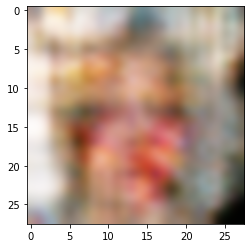

[0.04125145]
Progress: 41.54 %    49792    Dloss: 55.996559143066406    err: 12199.0478515625    Sample time: 0.774s    _

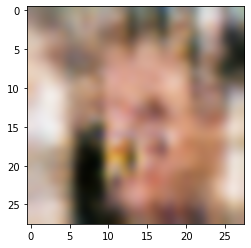

[0.05897781]


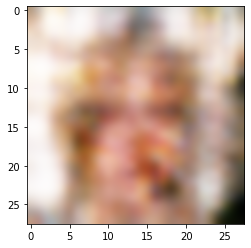

[0.00152978]
Progress: 44.74 %    52992    Dloss: 37.241180419921875    err: 16861.97265625    Sample time: 0.794s    _ _

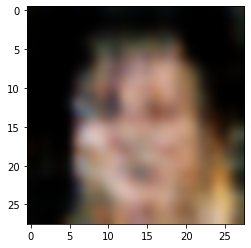

[0.13634814]


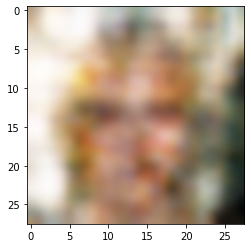

[0.0408369]
Progress: 47.94 %    56192    Dloss: 38.89688491821289    err: 13817.82421875    Sample time: 0.779s    _  _

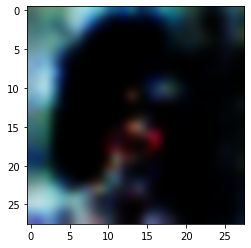

[0.01708622]


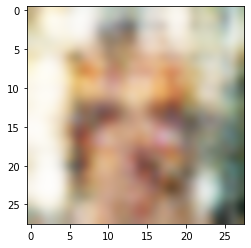

[0.00042998]
Progress: 51.14 %    59392    Dloss: 27.315298080444336    err: 11247.6787109375    Sample time: 0.794s    _

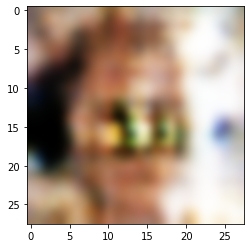

[0.00279482]


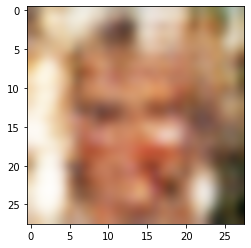

[0.00231521]
Progress: 54.34 %    62592    Dloss: 23.781539916992188    err: 13968.4541015625    Sample time: 0.791s    _

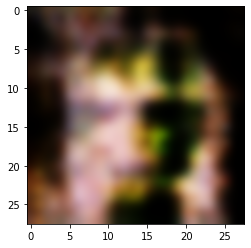

[0.9785462]


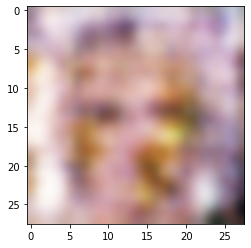

[0.01349207]
Progress: 57.54 %    65792    Dloss: 25.11244010925293    err: 14378.462890625    Sample time: 0.782s    ___

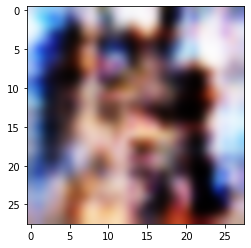

[0.00655086]


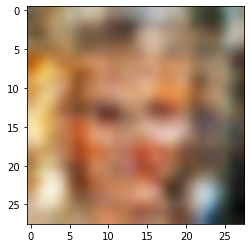

[0.00319711]
Progress: 60.74 %    68992    Dloss: 23.43857192993164    err: 15822.671875    Sample time: 0.780s    _  ___

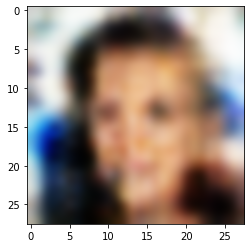

[0.75297683]


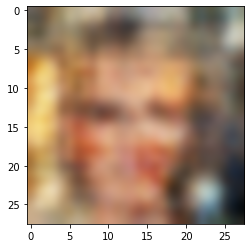

[0.30280173]
Progress: 63.94 %    72192    Dloss: 30.63234519958496    err: 13922.7421875    Sample time: 0.773s    _   _

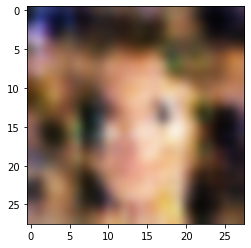

[0.2704835]


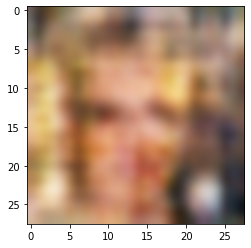

[0.05056829]
Progress: 67.14 %    75392    Dloss: 27.509103775024414    err: 14546.779296875    Sample time: 0.804s    __

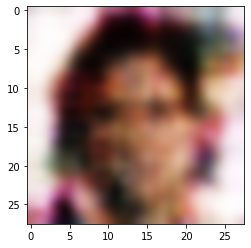

[0.00300257]


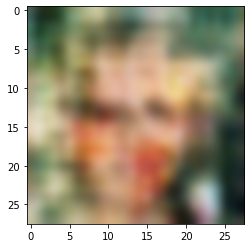

[0.37933218]
Progress: 70.34 %    78592    Dloss: 22.004901885986328    err: 11876.400390625    Sample time: 0.783s    __

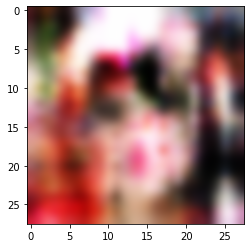

[0.90004545]


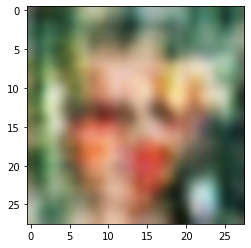

[0.0311601]
Progress: 73.54 %    81792    Dloss: 18.799497604370117    err: 13723.0224609375    Sample time: 0.810s    _

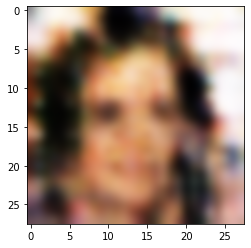

[0.03278144]


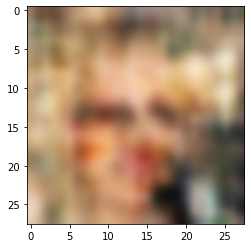

[0.00855183]
Progress: 76.74 %    84992    Dloss: 9.373082160949707    err: 9277.7138671875    Sample time: 0.790s    ___

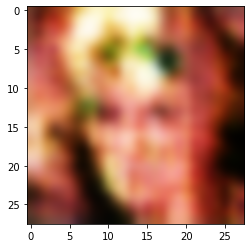

[0.03506311]


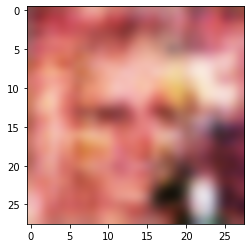

[0.00015358]
Progress: 79.94 %    88192    Dloss: 30.612892150878906    err: 13477.501953125    Sample time: 0.788s    __

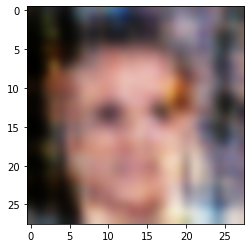

[0.01619074]


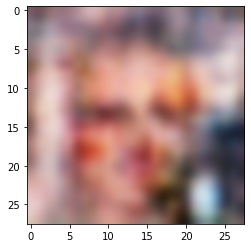

[0.02308757]
Progress: 83.14 %    91392    Dloss: 35.113365173339844    err: 19608.119140625    Sample time: 0.796s    __

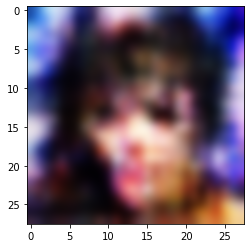

[0.9962986]


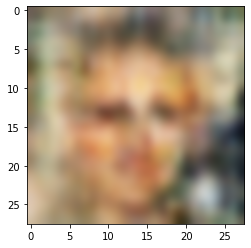

[0.03732411]
Progress: 86.34 %    94592    Dloss: 24.463985443115234    err: 12464.6494140625    Sample time: 0.783s    _

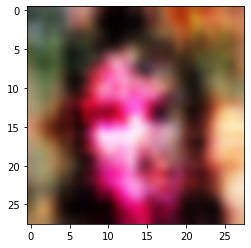

[5.9978283e-05]


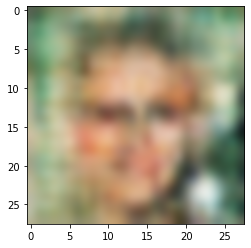

[0.01261875]
Progress: 89.54 %    97792    Dloss: 31.38111686706543    err: 12790.22265625    Sample time: 0.792s    _ __

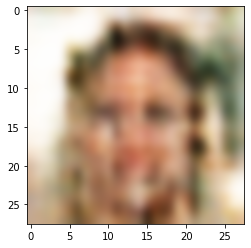

[0.0298041]


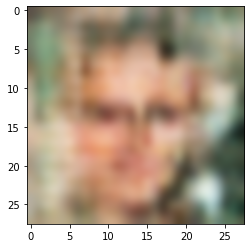

[0.43959904]
Progress: 91.71 %    99968    Dloss: 18.633691787719727    err: 10855.55859375    Sample time: 0.796s    ___

ValueError: operands could not be broadcast together with shapes (32,1) (64,1) 

In [26]:
epochs=2
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("\nEpoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    gen_sample()

## # Using generator with just batch size 1 for first time is causing images to be generated extreme

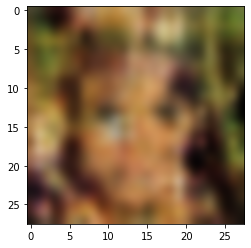

[0.13435422]


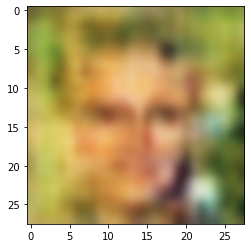

[0.13958141]


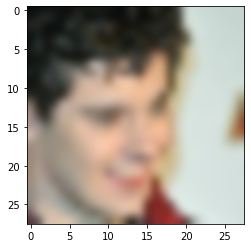

[[0.48502088]]


In [27]:
noise=np.random.randn(32,100).astype(np.float32)
gen=g.predict(noise)
gen_sample()
img=get_batch(np.random.randint(low=0,high=len(names)),1)
plt.imshow((img[0]+1)/2,interpolation='bicubic')
plt.show()
print(d.predict(img))

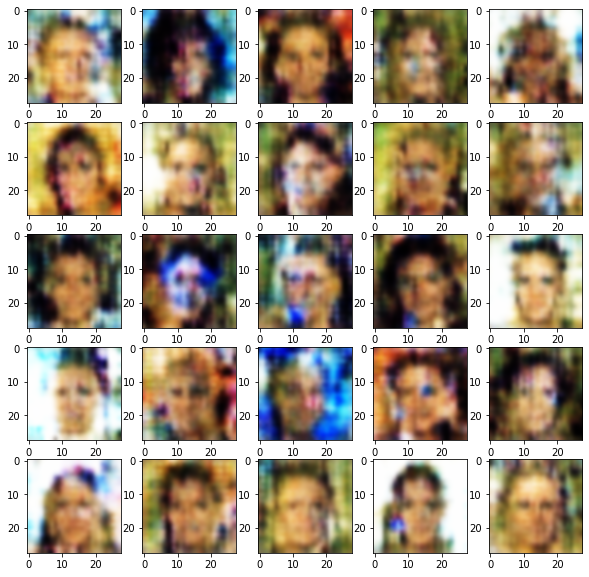

In [28]:
fig, ax = plt.subplots(nrows=5,ncols=5,figsize=[10,10])
fig.patch.set_facecolor('white')
noise=np.random.randn(25,100).astype(np.float32)
gen=g.predict(noise)
for i,axi in enumerate(ax.flat):
    axi.imshow((gen[i].squeeze()+1)/2,interpolation='bicubic')